# Explore entity mentions in the data

In [280]:
import os, pandas as pd, numpy as np

RESOURCE_PATH = "/data/medg/misc/semeval_2010"
from collections import Counter
def res(path): return os.path.join(RESOURCE_PATH, path)
import matplotlib.pyplot as plt
import math

In [211]:
relation_dictionary = {0:'Component-Whole(e2,e1)', 1:'Instrument-Agency(e2,e1)', 2:'Member-Collection(e1,e2)', 
3:'Cause-Effect(e2,e1)', 4:'Entity-Destination(e1,e2)', 5:'Content-Container(e1,e2)', 
6:'Message-Topic(e1,e2)', 7:'Product-Producer(e2,e1)', 8:'Member-Collection(e2,e1)', 
9:'Entity-Origin(e1,e2)', 10:'Cause-Effect(e1,e2)', 11:'Component-Whole(e1,e2)', 
12:'Message-Topic(e2,e1)', 13:'Product-Producer(e1,e2)', 14:'Entity-Origin(e2,e1)', 
15:'Content-Container(e2,e1)', 16:'Instrument-Agency(e1,e2)', 17:'Entity-Destination(e2,e1)',
18:'Other'}

type_of_relation = { 0: 'C-W', 1: 'I-A', 2: 'M-C', 3: 'C-E', 4: 'E-D', 5:'C-C',
                    6: 'M-T', 7:'P-P', 8: 'M-C', 9:'E-O', 10: 'C-E', 11:'C-W', 12:'M-T', 13:'P-P',
                    14:'E-O', 15:'C-C', 16:'I-A', 17:'E-D', 18:'O'
}
relation_dictionary_short = {0:'C-W2', 1:'I-A2', 2:'M-C1', 3:'C-E2', 4:'E-D1', 5:'C-C1', 
6:'M-T1', 7:'P-P2', 8:'M-C2', 9:'E-O1', 10:'C-E1', 11:'C-W1', 12:'M-T2', 13:'P-P1', 14:'E-O2', 
15:'C-C2', 16:'I-A1', 17:'E-D2',18:'_O'}


Is it possible for left entity to not be before right entity?

In [212]:
def left_after_right(filename):
    with open(res(filename)) as file:
        for line in file:
            line = line.split()
            relation = int(line[0])
            left_start = int(line[1])
            left_end = int(line[2])
            right_start = int(line[3])
            right_end = int(line[4])
            sentence = " ".join(str(x) for x in line[5:])
            list_sentence = line[5:]
            left = " ".join(str(x) for x in list_sentence[left_start:left_end+1])
            right = " ".join(str(x) for x in list_sentence[right_start:right_end+1])
            if left_start > right_start or left_end > right_end or left_start > right_end or left_end > right_start:
                print(
                    'Left: {}\n'
                    'Right: {}\n'
                    'Label: {}\n'
                    'Sentence: {}\n'\
                    .format(left, right, relation_dictionary[relation], sentence)
                )

In [213]:
left_after_right('train.txt')

In [214]:
left_after_right('test.txt')

## Create a pandas dataframe with Left Entity, Right Entity, Relation, Relation_Type, Sentence

In [215]:
def get_dataframe(filename):
    columns = ['Left Entity', 'Right Entity', 'Relation', 'Relation Type', 'Sentence']
    data = []
    num = 0
    with open(res(filename)) as file:
        for line in file:
            num += 1
            line = line.split()
            relation = int(line[0])
            left_start = int(line[1])
            left_end = int(line[2])
            right_start = int(line[3])
            right_end = int(line[4])
            sentence = " ".join(str(x) for x in line[5:])
            list_sentence = line[5:]
            left = " ".join(str(x) for x in list_sentence[left_start:left_end+1])
            right = " ".join(str(x) for x in list_sentence[right_start:right_end+1])
            data.append([left.lower(), right.lower(), relation_dictionary_short[relation], type_of_relation[relation],
                        sentence.lower()])
    df = pd.DataFrame(data, columns=columns)
    return df

In [362]:
train_data = get_dataframe('train.txt')

In [337]:
test_data = get_dataframe('test.txt')

# Methods to test entity mention commonalities

In [493]:
def group_and_get_relations(data, columns_duplicate):
    # columns can be ['Left Entity'] or ['Right Entity'] or ['Left Entity', 'Right Entity']
    data_len = len(data)
    data_copy = data.copy()
    data_copy = data_copy.reset_index()
    data_copy.rename(columns={'index': 'original data index'}, inplace=True)

    df_groupby = data_copy.groupby(columns_duplicate)
    df = df_groupby.size().reset_index(name='count') # get the counts after grouping
    df = df.loc[df['count'] > 1]
    df_len = len(df)
    print("Number of rows in data duplicated by ", columns_duplicate, " are", df_len)
    print("Out of the total ", data_len)
    print("This represents a percentage of %.2f"%(float(df_len)/data_len * 100))
    
    relation_list = df_groupby['Relation'].apply(list)
    relation_type_list = df_groupby['Relation Type'].apply(list)
    data_index = df_groupby['original data index'].apply(list)
    
    df.set_index(columns_duplicate, inplace=True)
    df = pd.concat([df, relation_list.rename('Relation'), relation_type_list.rename('Relation Type'), 
           train_data_index.rename('original data index')], axis=1, join='inner', sort=True)
    df.index.names = columns_duplicate
    df.reset_index(inplace=True)
    
    return df

In [475]:
# given a list like ['CE', 'CE'...] return a list like ['CE(2)']
def get_relation_num(relation):
    relation_count = Counter(relation)
    descending_order_relation_count = relation_count.most_common()
    rel_relnum = []
    most_common_relation_types = []
    most_common_relation_num = None
    max_count = 0
    for w in descending_order_relation_count:
        rel = w[0]
        count = w[1]
        rel_relnum.append(rel + "(" + str(count) + ")")
        if count > max_count:
            max_count = count
        if max_count == count:
            most_common_relation_types.append(rel)
            most_common_relation_num = count
    return rel_relnum, most_common_relation_types, most_common_relation_num

In [476]:
def get_relation_distributions(entity_duplicates, columns_duplicates):
    columns_df = []
    columns_df.extend(columns_duplicates)
    columns_df.extend(['count', 'Relation', 'Relation Type', 'Most common Relation Type', 
                       'Most common Relation Type num', 'original data index'])
    data = [] # Left Entity, count, Relation, Relation Type, 
    #Most common relation type, most common relation typenum, original data index
    # assume that you will get the input "columns"
    for index, row in entity_duplicates.iterrows():
        relation = row['Relation']
        relation_type = row['Relation Type']
        relation_and_count, _, _ = get_relation_num(relation)
        relation_type_and_count, most_common_relation_types,\
        most_common_relation_num = get_relation_num(relation_type)
        data_row = []
        for col in columns_duplicates: data_row.append(row[col])
        data_row.extend([row['count'], relation_and_count, relation_type_and_count,
                         most_common_relation_types, most_common_relation_num, row['original data index']])
        data.append(data_row)
    df = pd.DataFrame(data, columns=columns_df)
    return df


https://realpython.com/python-histograms/

In [477]:
def plot(columns, entity_relation_distributions):
    plt.style.use('ggplot')
    arr = entity_relation_distributions.hist(column='count', color='#6699cc', bins=30)
    # for i in range(10):
    #     plt.text(arr[0][i], arr[0][i],str(arr[0][i]))
    string = ""
    for col in columns: string += col + ", "
    plt.title('Counts for ' + string.strip())
    plt.xlabel('Number of duplicates')
    plt.ylabel('Counts')
    plt.grid(axis='y', alpha=0.75)

In [514]:
def get_relation_distributions_plot(data, columns, counts, percentage):
    # counts refers to printing those rows with counts greater than that value
    # percentage refers to printing the percentage of rows which have Most common rel type > percentage of count
    entity_duplicates = group_and_get_relations(data, columns)
    # get the relation distributions
    entity_relation_distributions = get_relation_distributions(entity_duplicates, columns)
    entity_relation_distributions = entity_relation_distributions.sort_values(by=['count'], ascending=False).reset_index(drop=True)
    # do the plotting
    plot(columns, entity_relation_distributions)
    
    entity_relation_dist_len = len(entity_relation_distributions)
    filtered_entit_rel_dist_len = len(entity_relation_distributions[entity_relation_distributions['Most common Relation Type num']
                                                                   > percentage * entity_relation_distributions['count']])
    percent_duplicate = float(filtered_entit_rel_dist_len) / entity_relation_dist_len * 100
      
    print("There are %.2f percent of entities with more than %.2f percent similar relations"%(percent_duplicate, 
                                                                                             percentage * 100))
    return entity_relation_distributions.loc[entity_relation_distributions['count'] > counts]

## Test how many individual entity mentions are the same, get their most common relations

Number of rows in data duplicated by  ['Left Entity']  are 1395
Out of the total  8000
This represents a percentage of 17.44
There are 52.19 percent of entities with more than 60.00 percent similar relations


,Left Entity,count,Relation,Relation Type,Most common Relation Type,Most common Relation Type num,original data index
0,book,65,"[P-P1(22), M-T1(20), _O(10), C-W2(7), E-D1(3),...","[P-P(22), M-T(21), O(10), C-W(7), E-D(3), I-A(...",[P-P],22,"[198, 290, 397, 441, 696, 738, 776, 781, 959, ..."
1,bottle,46,"[C-C2(44), C-C1(1), E-D1(1)]","[C-C(45), E-D(1)]",[C-C],45,"[266, 630, 732, 900, 1024, 1100, 1356, 1465, 1..."
2,people,33,"[_O(11), E-D1(9), P-P2(3), I-A2(3), E-O1(3), M...","[O(11), E-D(9), E-O(4), P-P(3), I-A(3), M-T(2)...",[O],11,"[7, 155, 556, 740, 1490, 1638, 1771, 2344, 246..."
3,suitcase,33,"[C-C2(31), C-C1(2)]",[C-C(33)],[C-C],33,"[660, 943, 1119, 1941, 1971, 2025, 2073, 2213,..."
4,man,32,"[I-A2(10), _O(10), E-O1(5), P-P2(3), C-E1(3), ...","[I-A(10), O(10), E-O(5), P-P(3), C-E(3), E-D(1)]","[I-A, O]",10,"[227, 698, 842, 1175, 1508, 2113, 2329, 2453, ..."
5,company,31,"[P-P2(17), _O(11), E-D1(1), P-P1(1), M-C2(1)]","[P-P(18), O(11), E-D(1), M-C(1)]",[P-P],18,"[409, 1228, 1754, 2263, 2297, 2574, 2734, 3058..."
6,water,29,"[E-D1(15), E-O1(7), C-C1(5), C-E1(2)]","[E-D(15), E-O(7), C-C(5), C-E(2)]",[E-D],15,"[151, 368, 665, 756, 1006, 1674, 1852, 2545, 2..."
7,money,28,"[E-D1(17), C-C1(10), E-O1(1)]","[E-D(17), C-C(10), E-O(1)]",[E-D],17,"[244, 304, 567, 1240, 1680, 1683, 2702, 2813, ..."
8,damage,28,"[C-E2(25), _O(2), C-E1(1)]","[C-E(26), O(2)]",[C-E],26,"[87, 138, 624, 827, 977, 1182, 1675, 1827, 229..."
9,author,27,"[P-P2(14), _O(6), I-A2(5), E-O1(2)]","[P-P(14), O(6), I-A(5), E-O(2)]",[P-P],14,"[2, 477, 1337, 1419, 1737, 2343, 2852, 2935, 2..."


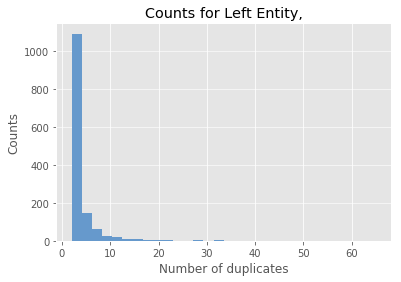

In [518]:
get_relation_distributions_plot(train_data, ['Left Entity'], 3, 0.6)

Number of rows in data duplicated by  ['Right Entity']  are 1410
Out of the total  8000
This represents a percentage of 17.62
There are 49.25 percent of entities with more than 60.00 percent similar relations


,Right Entity,count,Relation,Relation Type,Most common Relation Type,Most common Relation Type num,original data index
0,box,47,"[C-C1(40), E-D1(4), _O(2), C-C2(1)]","[C-C(41), E-D(4), O(2)]",[C-C],41,"[374, 514, 752, 3856, 4227, 4641, 5173, 7217, ..."
1,company,39,"[P-P1(21), _O(12), E-D1(3), C-W1(2), E-O1(1)]","[P-P(21), O(12), E-D(3), C-W(2), E-O(1)]",[P-P],21,"[409, 1228, 1754, 2263, 2297, 2574, 2734, 3058..."
2,book,26,"[P-P2(8), M-T2(6), C-W1(5), E-O1(3), _O(2), C-...","[P-P(8), M-T(6), C-W(5), E-O(3), O(2), C-C(1),...",[P-P],8,"[198, 290, 397, 441, 696, 738, 776, 781, 959, ..."
3,car,23,"[_O(10), I-A2(4), C-W1(4), C-C1(3), E-O1(2)]","[O(10), I-A(4), C-W(4), C-C(3), E-O(2)]",[O],10,"[174, 474, 1250, 2233, 3536, 3657, 4340, 4624,..."
4,water,22,"[C-C2(9), E-D1(4), _O(4), I-A2(3), C-E2(1), E-...","[C-C(9), E-D(4), O(4), I-A(3), C-E(1), E-O(1)]",[C-C],9,"[151, 368, 665, 756, 1006, 1674, 1852, 2545, 2..."
5,maker,20,"[P-P1(19), C-E1(1)]","[P-P(19), C-E(1)]",[P-P],19,"[3452, 3580, 3668, 4288]"
6,suitcase,20,"[C-C1(19), C-W1(1)]","[C-C(19), C-W(1)]",[C-C],19,"[660, 943, 1119, 1941, 1971, 2025, 2073, 2213,..."
7,building,19,"[C-W1(13), E-O1(2), _O(2), E-D1(2)]","[C-W(13), E-O(2), O(2), E-D(2)]",[C-W],13,"[4127, 4710, 4916, 6132, 6407, 6504, 7218, 722..."
8,books,19,"[M-C2(5), C-C2(4), E-O1(3), M-T2(2), E-D1(1), ...","[M-C(5), C-C(4), E-O(3), M-T(2), E-D(1), P-P(1...",[M-C],5,"[768, 4418, 4720, 5721, 7079]"
9,earthquake,18,"[C-E2(17), C-E1(1)]",[C-E(18)],[C-E],18,"[268, 428, 1572, 2735, 3809, 3926, 4037, 5114]"


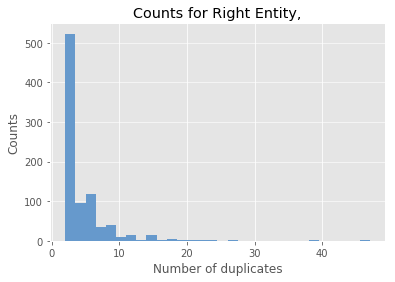

In [520]:
get_relation_distributions_plot(train_data, ['Right Entity'], 3, 0.6)

also check how many are same across left and right entity

## Number of duplicates across left and right entity (after removing duplicates within individual columns)

In [536]:
def get_df_without_duplicates(data, columns_duplicate):
    data = train_data
    data_len = len(data)
    data_copy = data.copy()
    data_copy = data_copy.reset_index()
    data_copy.rename(columns={'index': 'original data index'}, inplace=True)

    df_groupby = data_copy.groupby(columns_duplicate)
    df = df_groupby.size().reset_index(name='count') # get the counts after grouping
    df = df.loc[df['count'] == 1]
    df_len = len(df)

    # create a new dataframe with these filtered values
    relation_list = df_groupby['Relation'].apply(list)
    relation_type_list = df_groupby['Relation Type'].apply(list)
    data_index = df_groupby['original data index'].apply(list)

    df.set_index(columns_duplicate, inplace=True)
    df = pd.concat([df, relation_list.rename('Relation'), relation_type_list.rename('Relation Type'), 
           train_data_index.rename('original data index')], axis=1, join='inner', sort=True)
    df.index.names = columns_duplicate
    df.reset_index(inplace=True)

    new_data = []
    for index, row in df.iterrows():
        new_data_row = []
        for col in columns_duplicate: new_data_row.append(row[col])
        new_data_row.extend([row['Relation'][0], row['Relation Type'][0], row['original data index'][0]])
        new_data.append(new_data_row)
    columns_df = []
    columns_df.extend(columns_duplicate)
    columns_df.extend(['Relation', 'Relation Type', 'original data index'])
    new_df = pd.DataFrame(new_data, columns=columns_df)
    #also need to group by right entity 
    return new_df

In [544]:
left_entity_no_duplicates = get_df_without_duplicates(train_data, ['Left Entity'])
left_entity_no_duplicates.rename(columns={'Left Entity': 'Entity'}, inplace=True)

In [545]:
right_entity_no_duplicates = get_df_without_duplicates(train_data, ['Right Entity'])
right_entity_no_duplicates.rename(columns={'Right Entity': 'Entity'}, inplace=True)

In [548]:
concatenated_df = pd.concat([left_entity_no_duplicates, right_entity_no_duplicates])

Number of rows in data duplicated by  ['Entity']  are 377
Out of the total  3080
This represents a percentage of 12.24
There are 25.73 percent of entities with more than 70.00 percent similar relations


,Entity,count,Relation,Relation Type,Most common Relation Type,Most common Relation Type num,original data index
0,academic,2,"[P-P2(1), P-P1(1)]",[P-P(2)],[P-P],2,[3057]
1,pier,2,"[_O(1), C-W1(1)]","[O(1), C-W(1)]","[O, C-W]",1,[815]
2,points,2,[_O(2)],[O(2)],[O],2,[3440]
3,poetry,2,"[C-W1(1), E-D1(1)]","[C-W(1), E-D(1)]","[C-W, E-D]",1,[5712]
4,plates,2,"[C-W1(1), P-P2(1)]","[C-W(1), P-P(1)]","[C-W, P-P]",1,[2288]
5,plastic,2,"[_O(1), C-C1(1)]","[O(1), C-C(1)]","[O, C-C]",1,[7577]
6,plasma,2,"[_O(1), E-O1(1)]","[O(1), E-O(1)]","[O, E-O]",1,[1855]
7,planet,2,"[_O(1), C-W1(1)]","[O(1), C-W(1)]","[O, C-W]",1,[7647]
8,pilot,2,[_O(2)],[O(2)],[O],2,[2035]
9,pills,2,"[C-E1(1), I-A2(1)]","[C-E(1), I-A(1)]","[C-E, I-A]",1,[4646]


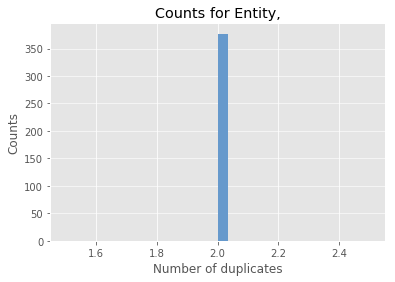

In [553]:
get_relation_distributions_plot(concatenated_df, ['Entity'], 1, 0.7)

## How many entity pairs are the same, and what are their relation distributions?

In [521]:
def group_left_and_right_entity(data, columns_duplicate=['Left Entity', 'Right Entity']):
    data_len = len(data)
    data_copy = data.copy()
    data_copy = data_copy.reset_index()
    data_copy.rename(columns={'index': 'original data index'}, inplace=True)

    df_groupby = data_copy.groupby(columns_duplicate)
    df = df_groupby.size().reset_index(name='count') # get the counts after grouping
    df = df.loc[df['count'] > 1]
    df_len = len(df)
    print("Number of rows in data duplicated by ", columns_duplicate, " are", df_len)
    print("Out of the total ", data_len)
    print("This represents a percentage of %.2f"%(float(df_len)/data_len * 100))

In [522]:
group_left_and_right_entity(train_data)

Number of rows in data duplicated by  ['Left Entity', 'Right Entity']  are 237
Out of the total  8000
This represents a percentage of 2.96


It doesn't seem like seeing whether Right Entity, Left Entity duplicates are present at the moment because the numbers are so small anyway

The only way to tell if the coupling will help is to see if the examples the model is performing badly on are the ones that have duplicating entity mentions or entity pair mentions